# Modele de CNN multihead  

In [1]:
# Package 
import pandas as pd
import numpy as np
from numpy import array
from numpy import hstack

In [296]:
X_Y = pd.read_csv(r'C:\Users\louis\OneDrive\Documents\ENSAE\2A\Safran\X_Y.csv')

In [297]:
X_Y =X_Y.drop('Unnamed: 0', axis= 1)

In [298]:
X_Y

,engine_serial_number,engine_series,cycles_counter,config_A,config_B,Interpolate_var_mot_1,Interpolate_flight_leg_hours,Interpolate_SV_rank,Interpolate_WW_rank,Interpolate_Config_B_rank,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_4,Interpolate_var_env_5,id_int,Interpolate_egt_slope
0,0.101545,0.0,0.479729,0.333333,1.0,0.323262,0.123242,0.333333,8.0,0.6,0.001248,0.000382,0.469181,0.0,0.184318,1823.0,-0.027761
1,0.101545,0.0,0.481815,0.333333,1.0,0.361258,0.101395,0.333333,8.0,0.6,0.003273,0.002476,0.635294,0.0,0.111111,1823.0,-0.027761
2,0.101545,0.0,0.486899,0.333333,1.0,0.414033,0.169298,0.333333,8.0,0.6,0.002293,0.001096,0.538408,0.0,0.094444,1823.0,-0.027761
3,0.101545,0.0,0.488593,0.333333,1.0,0.432734,0.157616,0.333333,8.0,0.6,0.002097,0.008403,0.505882,0.0,0.136905,1823.0,-0.027761
4,0.101545,0.0,0.482858,0.333333,1.0,0.374153,0.147661,0.333333,8.0,0.6,0.000319,0.008403,0.435294,0.0,0.198413,1823.0,-0.027761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661595,0.000000,0.0,0.033372,0.000000,0.0,0.608278,0.097098,0.000000,0.0,0.0,0.004110,0.029978,0.647059,0.0,0.146825,8438.0,-0.029193
661596,0.000000,0.0,0.070786,0.000000,0.0,0.619473,0.139931,0.000000,0.0,0.0,0.001175,0.046879,0.623529,0.0,0.099206,8438.0,-0.029193
661597,0.000000,0.0,0.106114,0.000000,0.0,0.569125,0.087680,0.000000,0.0,0.0,0.001327,0.019891,0.470588,0.0,0.107143,8438.0,-0.029193
661598,0.000000,0.0,0.150828,0.000000,0.0,0.463550,0.090001,0.000000,0.0,0.0,0.007807,0.024678,0.400000,0.0,0.172619,8438.0,-0.029193


## Prétraitement des variables environnementales

A partir de ce dataframe, on souhaite décomposer les séries des variables environnementales en 3 séries :
- tendance 
- saisonnalité 
- bruit 

afin de les intégrer dans différentes branches du réseau de neurones

In [299]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [300]:
dfs = np.array_split(X_Y[['Interpolate_var_env_1','Interpolate_var_env_2', 'Interpolate_var_env_3', 'Interpolate_var_env_4', 'Interpolate_var_env_5', 'id_int']], 6616)

In [301]:
dfs[0]

,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_4,Interpolate_var_env_5,id_int
0,0.001248,0.000382,0.469181,0.0,0.184318,1823.0
1,0.003273,0.002476,0.635294,0.0,0.111111,1823.0
2,0.002293,0.001096,0.538408,0.0,0.094444,1823.0
3,0.002097,0.008403,0.505882,0.0,0.136905,1823.0
4,0.000319,0.008403,0.435294,0.0,0.198413,1823.0
...,...,...,...,...,...,...
95,0.001151,0.008403,0.423529,0.0,0.186508,1823.0
96,0.003734,0.008403,0.517647,0.0,0.186508,1823.0
97,0.003251,0.001930,0.564706,0.0,0.156746,1823.0
98,0.000106,0.007237,0.590643,0.0,0.126563,1823.0


In [256]:
frequence = 6

In [785]:
def decompose_serie (serie, frequence ):
    df_trend = pd.DataFrame(columns=['Var_1_trend','Var_2_trend','Var_3_trend','Var_4_trend' , 'Var_5_trend', 'id_int'])
    df_season = pd.DataFrame(columns=['Var_1_season','Var_2_season','Var_3_season','Var_4_season' , 'Var_5_season', 'id_int'])
    df_resid = pd.DataFrame(columns=['Var_1_resid','Var_2_resid','Var_3_resid','Var_4_resid' , 'Var_5_resid', 'id_int'])

    for i in range(len(serie)) :
        result_1 = seasonal_decompose(serie[i]['Interpolate_var_env_1'], model='additive', freq=frequence)
        result_2 = seasonal_decompose(serie[i]['Interpolate_var_env_2'], model='additive', freq=frequence)
        result_3 = seasonal_decompose(serie[i]['Interpolate_var_env_3'], model='additive', freq=frequence)
        result_4 = seasonal_decompose(serie[i]['Interpolate_var_env_4'], model='additive', freq=frequence)
        result_5 = seasonal_decompose(serie[i]['Interpolate_var_env_5'], model='additive', freq=frequence)

        df_trend_i= pd.DataFrame({'Var_1_trend': result_1.trend ,'Var_2_trend' : result_2.trend,'Var_3_trend':result_3.trend,'Var_4_trend': result_4.trend, 'Var_5_trend':result_5.trend, 'id_int': dfs[i].id_int})
        df_trend_i= df_trend_i.fillna(df_trend_i.ffill())
        df_trend_i= df_trend_i.fillna(df_trend_i.bfill())
        df_trend = pd.concat([df_trend,df_trend_i])

        df_season_i= pd.DataFrame({'Var_1_season': result_1.seasonal ,'Var_2_season' : result_2.seasonal,'Var_3_season':result_3.seasonal,'Var_4_season': result_4.seasonal, 'Var_5_season':result_5.seasonal, 'id_int': dfs[i].id_int})
        df_season = pd.concat([df_season,df_season_i])

        df_resid_i= pd.DataFrame({'Var_1_resid': result_1.resid,'Var_2_resid' : result_2.resid,'Var_3_resid':result_3.resid,'Var_4_resid': result_4.resid, 'Var_5_resid':result_5.resid, 'id_int': dfs[i].id_int})
        df_resid_i= df_resid_i.fillna(df_resid_i.ffill())
        df_resid_i= df_resid_i.fillna(df_resid_i.bfill())
        df_resid = pd.concat([df_resid,df_resid_i])

        if i == int(len(serie)/4):
            print("25% du traitement effectué")
        if i == int(len(serie)/2):
            print("50% du traitement effectué")
        if i == int(len(serie) *(3/4)):
            print("75% du traitement effectué")
        if i == int(len(serie)-1):
            print("Terminé ! ")
    return df_trend, df_season, df_resid

In [786]:
df_trend, df_season, df_resid = decompose_serie (dfs, 6 )

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  if __name__ == '__main__':
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  # This is added back by InteractiveShellApp.init_path()


25% du traitement effectué
50% du traitement effectué
75% du traitement effectué
Terminé ! 


In [372]:
df_complement = X_Y[['engine_serial_number', 'engine_series', 'cycles_counter', 'config_A',
       'config_B', 'Interpolate_var_mot_1', 'Interpolate_flight_leg_hours',
       'Interpolate_SV_rank', 'Interpolate_WW_rank','Interpolate_Config_B_rank','Interpolate_egt_slope']]

On souhaite couper ce dataframe en échantillon de taille 100, où à chaque échantillon correspond une valeur de pente pour la marge EGT. 

In [373]:
def split_sequences_X_Y(sequences, n_steps) : 
    X, y = list(), list()
    n_iteration = int(len(sequences)/n_steps)
    if len(sequences)%n_steps != 0 : 
        print("Attention, modulo différent de zero")
    for i in range(n_iteration): 
        seq_x, seq_y = sequences [i*n_steps :(i+1)*n_steps, :-1 ], sequences[i*n_steps ,-1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)    

In [871]:
X_complement, y = split_sequences_X_Y(df_complement.values, 100)

In [375]:
def split_sequences_X(sequences, n_steps) : 
    X= list()
    n_iteration = int(len(sequences)/n_steps)
    if len(sequences)%n_steps != 0 : 
        print("Attention, modulo différent de zero")
    for i in range(n_iteration): 
        seq_x = sequences [i*n_steps :(i+1)*n_steps,:-1]
        X.append(seq_x)
    return array(X)

In [376]:
X_trend, X_season, X_resid =  split_sequences_X(df_trend.values, 100), split_sequences_X(df_season.values, 100), split_sequences_X(df_resid.values, 100)

In [377]:
from sklearn.model_selection import train_test_split

In [378]:
X_complement_train, X_complement_test, X_trend_train , X_trend_test, X_season_train, X_season_test, X_resid_train, X_resid_test, Y_train, Y_test = train_test_split(X_complement,X_trend,X_season,X_resid, y, test_size = 0.2, random_state=42)

## Le modèle 

In [687]:
# Importation des packages de deep learning 
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential 
from tensorflow.keras.layers import (Conv1D, Dense,Dropout, Flatten,MaxPooling1D, concatenate)
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import Input
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [773]:
# first input model
visible1 = Input(shape=(100, 10))
cnn1 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible1)
cnn1 = MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Flatten()(cnn1)

In [774]:
visible2 = Input(shape=(100, 5))
cnn2 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible2)
cnn2 = MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)

In [775]:
visible3 = Input(shape=(100, 5))
cnn3 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible3)
cnn3 = MaxPooling1D(pool_size=2)(cnn3)
cnn3 = Flatten()(cnn3)

In [776]:
visible4 = Input(shape=(100, 5))
cnn4 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible4)
cnn4 = MaxPooling1D(pool_size=2)(cnn4)
cnn4 = Flatten()(cnn4)

In [777]:
# merge input models
merge = concatenate([cnn1, cnn2, cnn3, cnn4])
dense = Dense(20, activation='relu')(merge)
output = Dense(1)(dense)

In [778]:
model = Model(inputs=[visible1, visible2,visible3,visible4 ], outputs=output)

In [779]:
model.compile(optimizer='adam', loss='mse')

In [780]:
# La condition suivante permet d'arrêter l'entrainement si le modéle n'apprend pas pendant 5 périodes : 
earlystop = EarlyStopping(patience=5) 
callbacks = [earlystop]

In [781]:
history= model.fit([X_complement_train, X_trend_train, X_season_train, X_resid_train], Y_train, epochs=20, validation_split = 0.2, callbacks=callbacks)

Epoch 1/20
133/133 [==============================] - 1s 7ms/step - loss: 0.0636 - val_loss: 0.0040
Epoch 2/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0458 - val_loss: 0.0037
Epoch 3/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0457 - val_loss: 0.0037
Epoch 4/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0457 - val_loss: 0.0037
Epoch 5/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0457 - val_loss: 0.0037
Epoch 6/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0457 - val_loss: 0.0037
Epoch 7/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0457 - val_loss: 0.0037
Epoch 8/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0457 - val_loss: 0.0037


In [782]:
test_loss = model.evaluate([X_complement_test, X_trend_test, X_season_test, X_resid_test], Y_test)

42/42 [==============================] - 0s 3ms/step - loss: 0.0319


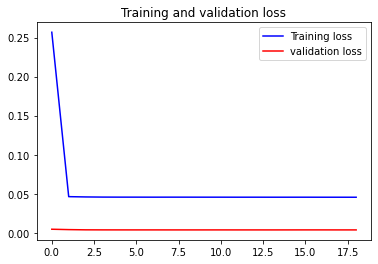

In [772]:
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.title('Training and validation loss')

legend = plt.legend()
plt.show()

In [ ]:
X_complement_train, X_complement_test, X_trend_train , X_trend_test, X_season_train, X_season_test, X_resid_train, X_resid_test, Y_train, Y_test = train_test_split(X_complement,X_trend,X_season,X_resid, y, test_size = 0.2, random_state=42)

In [876]:
choix_frequence(dfs, [5,10])

Epoch 1/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0435 - val_loss: 0.0037
Epoch 2/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0435 - val_loss: 0.0037
Epoch 3/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0435 - val_loss: 0.0037
Epoch 4/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0435 - val_loss: 0.0037
Epoch 5/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0435 - val_loss: 0.0037
Epoch 6/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0435 - val_loss: 0.0037
Epoch 7/20
133/133 [==============================] - 1s 7ms/step - loss: 0.0435 - val_loss: 0.0037
Epoch 8/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0435 - val_loss: 0.0037
Epoch 9/20
133/133 [==============================] - 1s 6ms/step - loss: 0.0435 - val_loss: 0.0037
oko


In [902]:
def choix_frequence (serie, frequences) : 
    df_result_freq = pd.DataFrame(columns=['Frequence','Loss'])
    for frequence in frequences : 
        print("En cours de traitement de la fréquence : ", frequence)
        df_trend, df_season, df_resid = decompose_serie (serie, frequence)
        X_trend, X_season, X_resid =  split_sequences_X(df_trend.values, 100), split_sequences_X(df_season.values, 100), split_sequences_X(df_resid.values, 100)
        (X_complement_train, X_complement_test, X_trend_train , X_trend_test, X_season_train, X_season_test, X_resid_train, X_resid_test, Y_train, Y_test) = train_test_split(X_complement,X_trend,X_season,X_resid, y, test_size = 0.2)
        history= model.fit([X_complement_train, X_trend_train, X_season_train, X_resid_train], Y_train, epochs=20, validation_split = 0.2, callbacks=callbacks)
        test_loss = model.evaluate([X_complement_test, X_trend_test, X_season_test, X_resid_test], Y_test)
        df_result_freq_i = pd.DataFrame({'Frequence': [frequence] ,'Var_2_trend' : [test_loss]})
        df_result_freq = pd.concat([df_result_freq,df_result_freq_i])
    return df_result_freq

In [903]:
df_result_freq = choix_frequence (dfs, [1,5,10,15,20,25,30,35,40,45,50])

En cours de traitement de la fréquence :  1


C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  if __name__ == '__main__':
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  # This is added back by InteractiveShellApp.init_path()


25% du traitement effectué
50% du traitement effectué
75% du traitement effectué
Terminé ! 
Epoch 1/20
133/133 [==============================] - 1s 7ms/step - loss: 0.0268 - val_loss: 0.0021
Epoch 2/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0268 - val_loss: 0.0020
Epoch 3/20
133/133 [==============================] - 1s 9ms/step - loss: 0.0268 - val_loss: 0.0020
Epoch 4/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0268 - val_loss: 0.0020
Epoch 5/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0268 - val_loss: 0.0020
Epoch 6/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0268 - val_loss: 0.0021
Epoch 7/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0268 - val_loss: 0.0020
Epoch 8/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0268 - val_loss: 0.0021
Epoch 9/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0268 - val_loss: 0.0020
Epoch 10

In [904]:
df_result_freq

,Frequence,Loss,Var_2_trend
0,1,NaN,0.093775
0,5,NaN,0.022926
0,10,NaN,0.021899
0,15,NaN,0.003528
0,20,NaN,0.014393
0,25,NaN,0.102117
0,30,NaN,0.006719
0,35,NaN,0.011503
0,40,NaN,0.033328
0,45,NaN,0.028298


In [880]:
choix_frequence (dfs,[5,10])

C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  import sys
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  if __name__ == '__main__':
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\louis\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  # This is added back by InteractiveShellApp.init_path()


25% du traitement effectué
50% du traitement effectué
75% du traitement effectué
Terminé ! 
Epoch 1/20
133/133 [==============================] - 1s 7ms/step - loss: 0.0166 - val_loss: 0.0114
Epoch 2/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0166 - val_loss: 0.0114
Epoch 3/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0166 - val_loss: 0.0114
Epoch 4/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0165 - val_loss: 0.0114
Epoch 5/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0166 - val_loss: 0.0114
Epoch 6/20
133/133 [==============================] - 1s 7ms/step - loss: 0.0166 - val_loss: 0.0114
Epoch 7/20
133/133 [==============================] - 1s 8ms/step - loss: 0.0166 - val_loss: 0.0114
Epoch 8/20
133/133 [==============================] - 1s 7ms/step - loss: 0.0166 - val_loss: 0.0114
Epoch 9/20
133/133 [==============================] - 1s 7ms/step - loss: 0.0166 - val_loss: 0.0114
Epoch 10

ValueError: If using all scalar values, you must pass an index

In [814]:
choix_frequence (3, 1) 

array([[[0.10154525, 0.        , 0.47972885, ..., 0.33333333,
         8.        , 0.6       ],
        [0.10154525, 0.        , 0.48181463, ..., 0.33333333,
         8.        , 0.6       ],
        [0.10154525, 0.        , 0.48689871, ..., 0.33333333,
         8.        , 0.6       ],
        ...,
        [0.10154525, 0.        , 0.47894668, ..., 0.33333333,
         8.        , 0.6       ],
        [0.10154525, 0.        , 0.48246643, ..., 0.33333333,
         8.        , 0.6       ],
        [0.10154525, 0.        , 0.49146135, ..., 0.33333333,
         8.        , 0.6       ]],

       [[0.76600442, 0.        , 0.13062182, ..., 0.        ,
         2.        , 0.        ],
        [0.76600442, 0.        , 0.13831313, ..., 0.        ,
         2.        , 0.        ],
        [0.76600442, 0.        , 0.13218616, ..., 0.        ,
         2.        , 0.        ],
        ...,
        [0.76600442, 0.        , 0.13114327, ..., 0.        ,
         2.        , 0.        ],
        [0.7

In [425]:
X_trend_train.shape

(5292, 100, 5)

In [424]:
X_complement_train.shape

(5292, 100, 10)

In [426]:
# define two sets of inputs
inputA = Input(shape=(100,10))
inputB = Input(shape=(100,5))
# the first branch operates on the first input
x = Dense(8, activation="relu")(inputA)
x = Dense(4, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
y = Dense(64, activation="relu")(inputB)
y = Dense(32, activation="relu")(y)
y = Dense(4, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(2, activation="relu")(combined)
z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

In [427]:
history = model.fit([X_complement_train,X_trend_train], Y_train, epochs=10, validation_split = 0.2)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [409]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(100, X_complement_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [410]:
history = model.fit(X_complement_train, Y_train, epochs=10, validation_split = 0.2)

Epoch 1/10
133/133 [==============================] - 0s 3ms/step - loss: 0.1153 - val_loss: 0.0041
Epoch 2/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0038
Epoch 3/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0037
Epoch 4/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0037
Epoch 5/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0036
Epoch 6/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0036
Epoch 7/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0037
Epoch 8/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0035
Epoch 9/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0036
Epoch 10/10
133/133 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0036

In [414]:
X_complement_train.shape

(5292, 100, 10)

In [415]:
x_input = X_complement_train[0]
x_input = x_input.reshape((1, 100, 10))

In [416]:
x_input

array([[[0.04709345, 0.        , 0.20949029, 0.        , 1.        ,
         0.13685721, 0.13613258, 0.        , 2.        , 0.4       ],
        [0.04709345, 0.        , 0.19853996, 0.        , 1.        ,
         0.03921577, 0.21276349, 0.        , 2.        , 0.4       ],
        [0.04709345, 0.        , 0.20088646, 0.        , 1.        ,
         0.41974892, 0.26635718, 0.        , 2.        , 0.4       ],
        [0.04709345, 0.        , 0.19176118, 0.        , 1.        ,
         0.50566374, 0.15295494, 0.        , 2.        , 0.4       ],
        [0.04709345, 0.        , 0.20023465, 0.        , 1.        ,
         0.53477565, 0.20223274, 0.        , 2.        , 0.4       ],
        [0.04709345, 0.        , 0.20440621, 0.        , 1.        ,
         0.46138206, 0.12976427, 0.        , 2.        , 0.4       ],
        [0.04709345, 0.        , 0.18589493, 0.        , 1.        ,
         0.48140485, 0.19576851, 0.        , 2.        , 0.4       ],
        [0.04709345, 0.    

In [417]:
model.predict(x_input)

array([[-0.03070463]], dtype=float32)

In [418]:
Y_train[0]

-0.06207703

In [94]:
x_input = X_train[0:3]

In [95]:
x_input
x_input = x_input.reshape((3, 100, 15))

In [96]:
model.predict(x_input)

array([[ 0.30618152],
       [-0.5657972 ],
       [ 0.09630451]], dtype=float32)

In [97]:
model.predict(X_train[0:3])

array([[ 0.30618152],
       [-0.5657972 ],
       [ 0.09630451]], dtype=float32)

In [442]:
dfs[0]

,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_4,Interpolate_var_env_5,id_int
0,0.001248,0.000382,0.469181,0.0,0.184318,1823.0
1,0.003273,0.002476,0.635294,0.0,0.111111,1823.0
2,0.002293,0.001096,0.538408,0.0,0.094444,1823.0
3,0.002097,0.008403,0.505882,0.0,0.136905,1823.0
4,0.000319,0.008403,0.435294,0.0,0.198413,1823.0
...,...,...,...,...,...,...
95,0.001151,0.008403,0.423529,0.0,0.186508,1823.0
96,0.003734,0.008403,0.517647,0.0,0.186508,1823.0
97,0.003251,0.001930,0.564706,0.0,0.156746,1823.0
98,0.000106,0.007237,0.590643,0.0,0.126563,1823.0


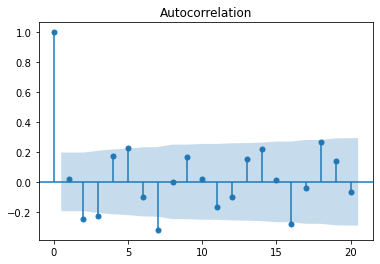

In [445]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

# Display the autocorrelation plot of your time series
fig = tsaplots.plot_acf(dfs[0]['Interpolate_var_env_5'])
plt.show()

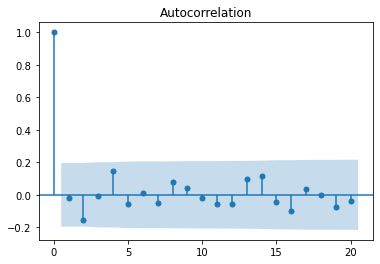

In [487]:
fig = tsaplots.plot_acf(dfs[7]['Interpolate_var_env_3'])
plt.show()

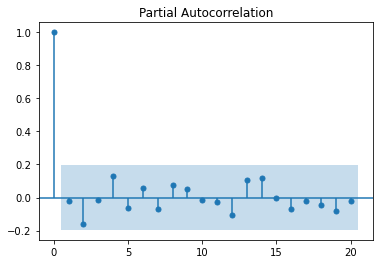

In [488]:
fig = tsaplots.plot_pacf(dfs[7]['Interpolate_var_env_3'])
plt.show()

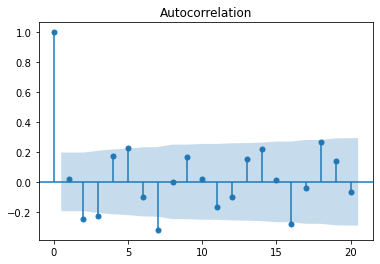

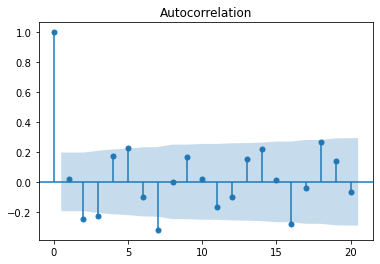

In [449]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(dfs[0]['Interpolate_var_env_5'])

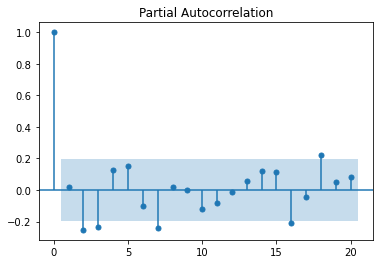

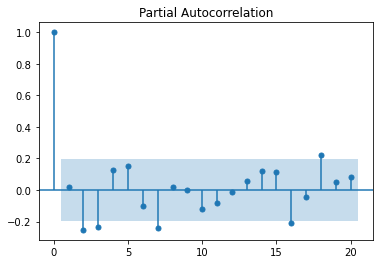

In [453]:
plot_pacf(dfs[0]['Interpolate_var_env_5'], lags=20)

In [459]:
X_Y[X_Y.engine_serial_number == 0 ].Interpolate_var_env_1

106000    0.003074
106001    0.003470
106002    0.002225
106003    0.001173
106004    0.008329
            ...   
661595    0.004110
661596    0.001175
661597    0.001327
661598    0.007807
661599    0.006232
Name: Interpolate_var_env_1, Length: 1800, dtype: float64

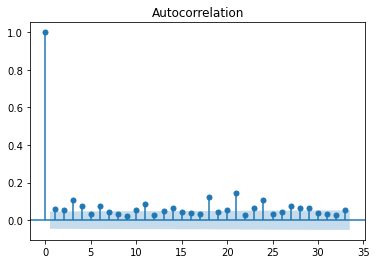

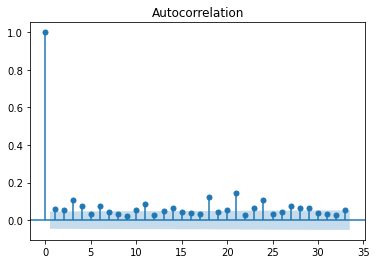

In [460]:
plot_acf(X_Y[X_Y.engine_serial_number == 0 ].Interpolate_var_env_1)

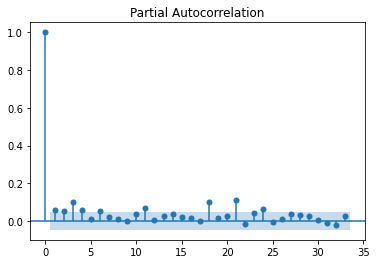

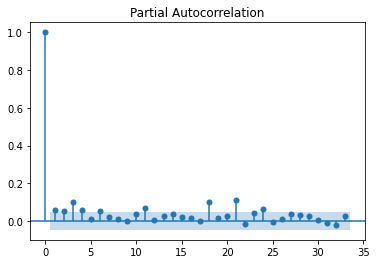

In [461]:
plot_pacf(X_Y[X_Y.engine_serial_number == 0 ].Interpolate_var_env_1)

In [462]:
pretraitement = pd.read_csv(r'C:\Users\louis\OneDrive\Documents\ENSAE\2A\Safran\pretraitement.csv')

In [469]:
pretraitement[pretraitement.engine_serial_number =='ESN_4' ].Interpolate_var_env_1

33036   -0.250298
33037    0.231598
33038   -0.462672
33039   -0.511420
33040   -0.497516
           ...   
36870   -0.453885
36871   -0.476415
36872   -0.528947
36873   -0.466439
36874    0.138512
Name: Interpolate_var_env_1, Length: 3839, dtype: float64

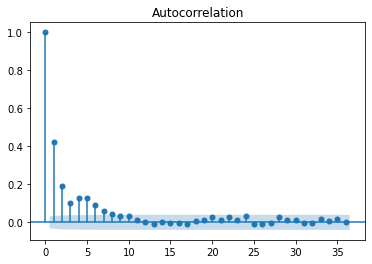

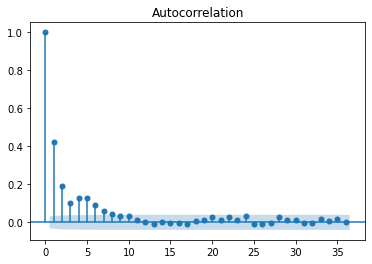

In [470]:
plot_acf(pretraitement[pretraitement.engine_serial_number =='ESN_4' ].Interpolate_var_env_1)

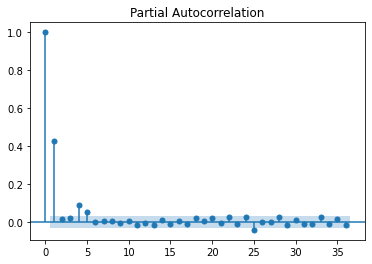

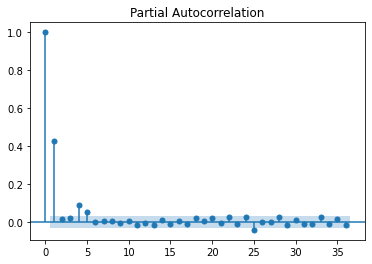

In [471]:
plot_pacf(pretraitement[pretraitement.engine_serial_number =='ESN_4' ].Interpolate_var_env_1)

In [ ]:
X_Y[X_Y.engine_serial_number == 0 ].Interpolate_var_env_1

In [457]:
X_Y

,engine_serial_number,engine_series,cycles_counter,config_A,config_B,Interpolate_var_mot_1,Interpolate_flight_leg_hours,Interpolate_SV_rank,Interpolate_WW_rank,Interpolate_Config_B_rank,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_4,Interpolate_var_env_5,id_int,Interpolate_egt_slope
0,0.101545,0.0,0.479729,0.333333,1.0,0.323262,0.123242,0.333333,8.0,0.6,0.001248,0.000382,0.469181,0.0,0.184318,1823.0,-0.027761
1,0.101545,0.0,0.481815,0.333333,1.0,0.361258,0.101395,0.333333,8.0,0.6,0.003273,0.002476,0.635294,0.0,0.111111,1823.0,-0.027761
2,0.101545,0.0,0.486899,0.333333,1.0,0.414033,0.169298,0.333333,8.0,0.6,0.002293,0.001096,0.538408,0.0,0.094444,1823.0,-0.027761
3,0.101545,0.0,0.488593,0.333333,1.0,0.432734,0.157616,0.333333,8.0,0.6,0.002097,0.008403,0.505882,0.0,0.136905,1823.0,-0.027761
4,0.101545,0.0,0.482858,0.333333,1.0,0.374153,0.147661,0.333333,8.0,0.6,0.000319,0.008403,0.435294,0.0,0.198413,1823.0,-0.027761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661595,0.000000,0.0,0.033372,0.000000,0.0,0.608278,0.097098,0.000000,0.0,0.0,0.004110,0.029978,0.647059,0.0,0.146825,8438.0,-0.029193
661596,0.000000,0.0,0.070786,0.000000,0.0,0.619473,0.139931,0.000000,0.0,0.0,0.001175,0.046879,0.623529,0.0,0.099206,8438.0,-0.029193
661597,0.000000,0.0,0.106114,0.000000,0.0,0.569125,0.087680,0.000000,0.0,0.0,0.001327,0.019891,0.470588,0.0,0.107143,8438.0,-0.029193
661598,0.000000,0.0,0.150828,0.000000,0.0,0.463550,0.090001,0.000000,0.0,0.0,0.007807,0.024678,0.400000,0.0,0.172619,8438.0,-0.029193


In [489]:
dfs[0]

,Interpolate_var_env_1,Interpolate_var_env_2,Interpolate_var_env_3,Interpolate_var_env_4,Interpolate_var_env_5,id_int
0,0.001248,0.000382,0.469181,0.0,0.184318,1823.0
1,0.003273,0.002476,0.635294,0.0,0.111111,1823.0
2,0.002293,0.001096,0.538408,0.0,0.094444,1823.0
3,0.002097,0.008403,0.505882,0.0,0.136905,1823.0
4,0.000319,0.008403,0.435294,0.0,0.198413,1823.0
...,...,...,...,...,...,...
95,0.001151,0.008403,0.423529,0.0,0.186508,1823.0
96,0.003734,0.008403,0.517647,0.0,0.186508,1823.0
97,0.003251,0.001930,0.564706,0.0,0.156746,1823.0
98,0.000106,0.007237,0.590643,0.0,0.126563,1823.0


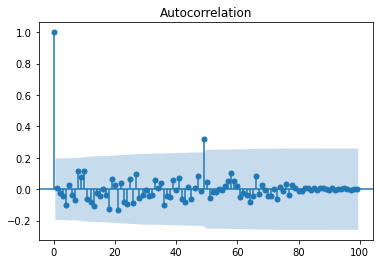

In [493]:
plot_acf(dfs[0]['Interpolate_var_env_1'], lags=99)
plt.show()

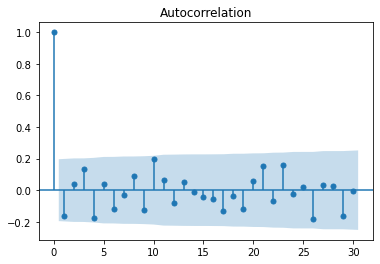

In [533]:
plot_acf(dfs[19]['Interpolate_var_env_5'], lags=30)
plt.show()

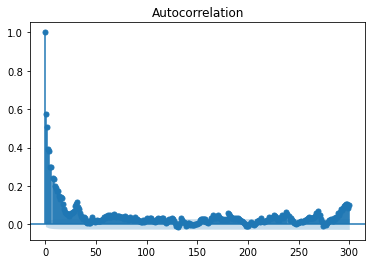

In [544]:
plot_acf(pretraitement[pretraitement.engine_serial_number =='ESN_1' ].Interpolate_var_env_1, lags = 300)
plt.show()